<a href="https://colab.research.google.com/github/Jason-Lian0126/python-ai-data-science/blob/main/kaggle_covid19_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
import pandas as pd

data = pd.read_csv('covid_19_data.csv')

In [ ]:
data = data.drop(columns=['SNo', 'Last Update'])
data = data.groupby(['ObservationDate', 'Country/Region'])[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
data['ObservationDate'] = pd.to_datetime(data['ObservationDate'])
data = data.set_index('ObservationDate')

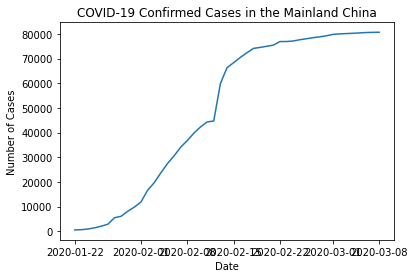

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data[data['Country/Region'] == 'Mainland China']['Confirmed'])
plt.title('COVID-19 Confirmed Cases in the Mainland China')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.show()

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9537133 sha256=442879cf04d4b2123d06a3eeaa2cf649627c13b4095a105637b2a0b904e0eac5
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.1.0
    Uninstalling cmdstanpy-1.1.0:
      Successfully uninstalled cmdstan

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


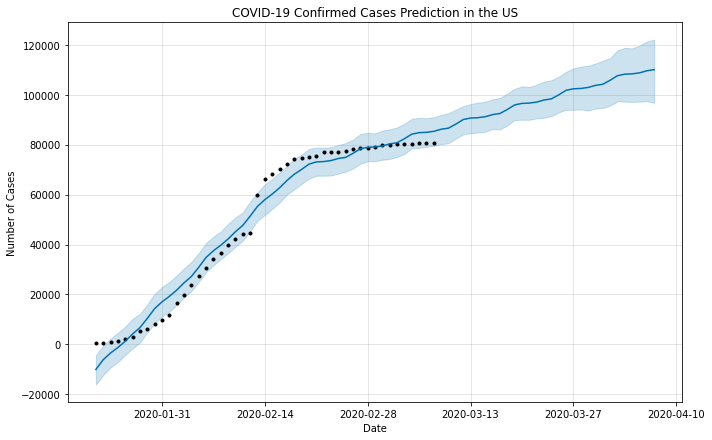

In [ ]:
#import prophet
from fbprophet import Prophet

# 設置Prophet模型
model = Prophet()

# 訓練數據格式必須為'ds'和'y'兩列，且列名必須是這樣的
confirmed = data[data['Country/Region'] == 'Mainland China'][['Confirmed']].reset_index().rename(columns={'ObservationDate':'ds', 'Confirmed':'y'})

# 訓練模型
model.fit(confirmed)

# 創建未來日期數據框
future = model.make_future_dataframe(periods=30)

# 預測未來確診病例數量
forecast = model.predict(future)

# 繪製預測結果
model.plot(forecast)
plt.title('COVID-19 Confirmed Cases Prediction in the US')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.show()

1/1 [==============================] - 0s 128ms/step


ValueError: ignored

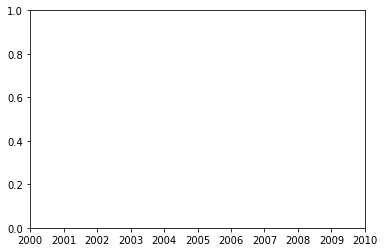

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# 載入數據集
data = pd.read_csv('covid_19_data.csv')

# 將日期格式化
data['ObservationDate'] = pd.to_datetime(data['ObservationDate'])

# 選擇要預測的國家/地區和變量
country = 'US'
variable = 'Confirmed'

# 選擇時間窗口大小
window_size = 7

# 篩選數據集
data = data[data['Country/Region'] == country][['ObservationDate', variable]]
data = data.groupby('ObservationDate').sum().reset_index()

# 設置訓練集和測試集
train_data = data.iloc[:-30]
test_data = data.iloc[-30:]

# 標準化數據
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[[variable]])
test_scaled = scaler.transform(test_data[[variable]])

# 創建時間序列數據
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled, train_scaled, window_size)
X_test, y_test = create_dataset(test_scaled, test_scaled, window_size)

# 創建LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 訓練模型
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0, shuffle=False)

# 使用模型進行預測
y_pred = model.predict(X_test)

# 還原數據的比例
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# 繪製預測結果
plt.plot(test_data['ObservationDate'], y_test, label='True')
plt.plot(test_data['ObservationDate'], y_pred, label='Predicted')
plt.title('COVID-19 Confirmed Cases Prediction in the US (LSTM)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

1/1 [==============================] - 0s 108ms/step


ValueError: ignored

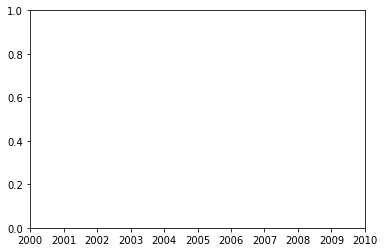

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt

# 載入數據集
data = pd.read_csv('covid_19_data.csv')

# 將日期格式化
data['ObservationDate'] = pd.to_datetime(data['ObservationDate'])

# 選擇要預測的國家/地區和變量
country = 'US'
variable = 'Confirmed'

# 選擇時間窗口大小
window_size = 7

# 篩選數據集
data = data[data['Country/Region'] == country][['ObservationDate', variable]]
data = data.groupby('ObservationDate').sum().reset_index()

# 設置訓練集和測試集
train_data = data.iloc[:-30]
test_data = data.iloc[-30:]

# 標準化數據
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[[variable]])
test_scaled = scaler.transform(test_data[[variable]])

# 創建時間序列數據
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled, train_scaled, window_size)
X_test, y_test = create_dataset(test_scaled, test_scaled, window_size)

# 創建RNN模型
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 訓練模型
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0, shuffle=False)

# 使用模型進行預測
y_pred = model.predict(X_test)

# 還原數據的比例
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# 繪製預測結果
plt.plot(test_data['ObservationDate'], y_test, label='True')
plt.plot(test_data['ObservationDate'], y_pred, label='Predicted')
plt.title('COVID-19 Confirmed Cases Prediction in the US (RNN)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


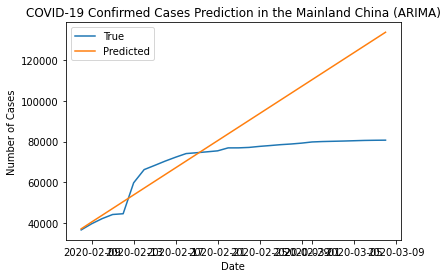

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 載入數據集
data = pd.read_csv('covid_19_data.csv')

# 將日期格式化
data['ObservationDate'] = pd.to_datetime(data['ObservationDate'])

# 選擇要預測的國家/地區和變量
country = 'Mainland China'
variable = 'Confirmed'

# 篩選數據集
data = data[data['Country/Region'] == country][['ObservationDate', variable]]
data = data.groupby('ObservationDate').sum().reset_index()

# 設置訓練集和測試集
train_data = data.iloc[:-30]
test_data = data.iloc[-30:]

# 創建ARIMA模型
model = ARIMA(train_data[variable], order=(2, 1, 2))
model_fit = model.fit()

# 使用模型進行預測
y_pred = model_fit.predict(len(train_data), len(train_data) + len(test_data) - 1, typ='levels')

# 繪製預測結果
plt.plot(test_data['ObservationDate'], test_data[variable], label='True')
plt.plot(test_data['ObservationDate'], y_pred, label='Predicted')
plt.title('COVID-19 Confirmed Cases Prediction in the Mainland China (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()